# Setup


## Imports
Later on in this file we're going to need to use a library, textstat, that isn't installed in Google Colab by default. We can hop out to the command line here and install it before we begin our coding. Then, we're going to import a bunch of libraries that will get used in our code. 

In [ ]:
!pip install textstat

     |████████████████████████████████| 105 kB 4.5 MB/s 
     |████████████████████████████████| 2.0 MB 34.6 MB/s 


In [ ]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import re
import calendar
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB 
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import spacy
from spacy.lang.en import English

import jieba
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

import textstat

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset downloads

Finally, we're going to bring in two files for analysis: 
- Our Alexa data for analysis
- A copy of the 2001 edition of the LIWC lexicons.

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp' -O alexa_train.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1BvnyCv32AgxyrC0a6EuQXFx21KQDUrzX' -O liwc2001.dic

--2022-04-04 19:00:24--  https://drive.google.com/uc?export=download&id=1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp
Resolving drive.google.com (drive.google.com)... 108.177.125.139, 108.177.125.113, 108.177.125.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jopnfsi9s55b6lrb8qp1n70pkb9nolpl/1649098800000/09640029349513786515/*/1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp?e=download [following]
--2022-04-04 19:00:27--  https://doc-0s-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jopnfsi9s55b6lrb8qp1n70pkb9nolpl/1649098800000/09640029349513786515/*/1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp?e=download
Resolving doc-0s-b0-docs.googleusercontent.com (doc-0s-b0-docs.googleusercontent.com)... 142.251.8.132, 2404:6800:4008:c15::84
Connecting to doc-0s-b0-docs.googleusercontent.com (doc-0s-b0-d

## Useful Functions
Let's also redefine several functions from the first weekend of class, so we have access to them here.

In [ ]:
# For feature inspection within a data frame.
def boxplot_values(df, target_column, feature_column, feature_names=None):
    vals = feature_names
    if vals is None:
      vals = df[feature_column].unique()
    subsets = []
    for v in vals:
        subsets.append(df.loc[df[feature_column] == v][target_column])
    print(len(subsets))
    plt.boxplot(subsets)
    plt.xticks(np.arange(1, len(vals)+1), vals)
    plt.xlabel(feature_column)
    plt.ylabel(target_column)
    plt.title(f'{target_column} vs {feature_column}')
    plt.show()


################################################################################
## Let's also bring back our functions for comparing classifiers              ##
################################################################################
"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""
# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

#Dont worry about these two lines

# Then define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle)


    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison
    

# Prerequisite Knowledge
To understand this notebook you should feel comfortable with the following topics
- Decision Trees and Logistic Regression
- Kappa and Accuracy Metrics
- Cross Validation and Comparing Models
- Understand all the "Useful Functions" from the cell above

# Working with Text Datasets

Text data is often much more computationally laborious to process and manage, compared to purely tabular data. We often must perform some serious preprocessing to get the data into a state that we can actually work with. Let's see some different ways that we can work with this kind of data, starting simple and moving forward with increasingly complex representations.

## Loading and Preprocessing the Data
We'll start off this notebook by loading in our file and seeing what the data looks like. 

In [ ]:
# Let's load our dataset and get rid of incomplete values and a useless column for us
filename = "alexa_train.csv"
df = pd.read_csv(filename)
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()

# This dataset is pretty large so lets shrink it down so the notebook runs faster
print('Original DataFrame Shape: ', df.shape)
df = df.loc[df.conv_id % 10 == 0].copy()
print('Shrunk DataFrame Shape:   ', df.shape)

Original DataFrame Shape:  (186015, 10)
Shrunk DataFrame Shape:    (18614, 10)


Let's look at the data directly and see what we have. We can see that each data point has quite a bit of associated information. 


In [ ]:
df

,conv_id,url,conf,message,agent,sentiment,source,turn_rating,agent_1_rating,agent_2_rating
191,100010,https://www.washingtonpost.com/lifestyle/style...,B,"Naming a cloned cat ""copy cat"", that's cute.",agent_1,Neutral,['FS3'],Excellent,Excellent,Good
192,100010,https://www.washingtonpost.com/lifestyle/style...,B,You must have ESP. I was going to tell you teh...,agent_2,Sad,['FS3'],Good,Excellent,Good
193,100010,https://www.washingtonpost.com/lifestyle/style...,B,Really? That's awful to hear!,agent_1,Surprised,['FS2'],Poor,Excellent,Good
194,100010,https://www.washingtonpost.com/lifestyle/style...,B,Of Roosevelt's 20 pets two were a bear and hyena!,agent_2,Surprised,['FS3'],Passable,Excellent,Good
195,100010,https://www.washingtonpost.com/lifestyle/style...,B,"Whoa, cool! I know he seemed to be quite the a...",agent_1,Surprised,['Personal Knowledge'],Poor,Excellent,Good
...,...,...,...,...,...,...,...,...,...,...
188192,108620,http://www.washingtonpost.com/education/2018/0...,B,I just heard about it recently. I did see him...,agent_2,Neutral,['FS1'],Excellent,Excellent,Excellent
188193,108620,http://www.washingtonpost.com/education/2018/0...,B,"Did someone walk a mile in someone's 5,000 yea...",agent_1,Surprised,['FS1'],Excellent,Excellent,Excellent
188194,108620,http://www.washingtonpost.com/education/2018/0...,B,"Yes, that's right. Years ago, shoes were more...",agent_2,Neutral,['FS1'],Excellent,Excellent,Excellent
188195,108620,http://www.washingtonpost.com/education/2018/0...,B,Fashion for sure and the prices for some are c...,agent_1,Surprised,['FS1'],Excellent,Excellent,Excellent


Let's take a closer look at what these messages look like to get a feeling for what sort of text we are working with.

In [ ]:
for i in range(10):
    print(df.iloc[i]["message"])

Naming a cloned cat "copy cat", that's cute.
You must have ESP. I was going to tell you teh same thing! I have a sad story to tell there are less tigers living in the wild in Asia than as pets in the US.
Really? That's awful to hear!
Of Roosevelt's 20 pets two were a bear and hyena!
Whoa, cool! I know he seemed to be quite the animal lover.
And there are more pets in Japan than there are children under 15. You can't be a pets "OWNER" in Boulder but you can be their guardian.  
I have a pet. I am an ailurophile meaning I love cats.
Cool word! Did you know there are 20 quintillion animal varieties on Earth?
That is a lot! And in 2002 Germany gave them legal rights.
Yeah, and the Loch Ness monster is protected under the 1912 Scottish Animal Protection Act.


We will want to classify the turn_rating and the sentiment based on the message text. Let's see what the distributions look like for these two variables and perform some preprocessing to simplify our classification tasks. 

In [ ]:
# Let's look at the distribution of sentiment and turn rating
print('Distribution of turn_rating')
print(df["turn_rating"].value_counts())
print('-------------------')
print('Distribution of sentiment')
print(df["sentiment"].value_counts())

Distribution of turn_rating
Excellent    9047
Good         8318
Passable     1068
Not Good      125
Poor           56
Name: turn_rating, dtype: int64
-------------------
Distribution of sentiment
Curious to dive deeper    7983
Neutral                   4268
Surprised                 2950
Happy                     2851
Sad                        223
Disgusted                  134
Fearful                    116
Angry                       89
Name: sentiment, dtype: int64


In [ ]:
# This creates a binary rating task instead of a more complex 5-label scale.
def simplify_rating(label):
  if label == "Excellent" or label == "Good":
    return "Positive"
  else:
    return "Neutral/Negative"

# This will produce a 4-label multiclass task, shrinking down from the eight labels 
# originally provided to us in the dataset.
def simplify_sentiment(label):
  if label in ["Sad", "Disgusted", "Fearful", "Angry"]:
      return "Negative"
  elif label in ["Happy", "Surprised"]:
      return "Positive"
  else:
      return label

df["rating_simple"] = df["turn_rating"].apply(simplify_rating)
df["sentiment_simple"] = df["sentiment"].apply(simplify_sentiment)

# Let's look at the new distributions of sentiment and turn rating
print('Distribution of rating_simple')
print(df["rating_simple"].value_counts())
print('-------------------')
print('Distribution of sentiment_simple')
print(df["sentiment_simple"].value_counts())

Distribution of rating_simple
Positive            17365
Neutral/Negative     1249
Name: rating_simple, dtype: int64
-------------------
Distribution of sentiment_simple
Curious to dive deeper    7983
Positive                  5801
Neutral                   4268
Negative                   562
Name: sentiment_simple, dtype: int64


## Count-Based Representations

Some ways of representing text are easy for us to implement ourselves. Others require a little more work and so we bring in the textstat library to do some work for us.

As we look through the different metrics that can be produced here, it's important to note that they are often tweaks on the same basic idea: readability and grade level, for instance, are highly correlated and make only slightly different assumptions about what matters most when evaluating a text.

The simplest way that we can represent our message is just by its length. Two ways that we can go about that is by counting the number of words in the message or the number of sentences in the message. This can be implemented in python in the following way:

- Split the text by some character (for words, we use spaces and, for sentences, we use periods)
- Compute the length of this new list of strings

Lets see what the distribution of message length looks like for both words and sentences. 

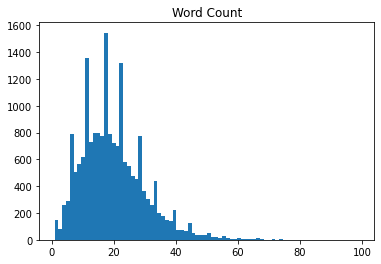

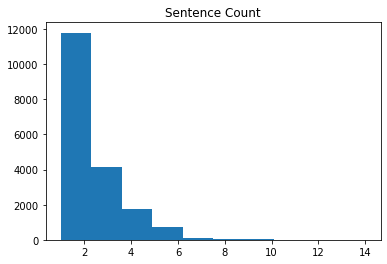

In [ ]:
def count_words(text):
    return len(text.split(' '))

def count_sentences(text):
    return len(text.split("."))

df["word_count"] = df["message"].apply(count_words)
df["sentence_count"] = df["message"].apply(count_sentences)

plt.title('Word Count')
plt.hist(df["word_count"], bins=80)
plt.show()

plt.title('Sentence Count')
plt.hist(df["sentence_count"], bins=10)
plt.show()

Let's try getting some more advanced statistics about our data as well. Here, we will use the [textstat library](https://github.com/shivam5992/textstat) to compute the following for each message and add it to our dataframe:

- The number of words 
- The number of sentences 
- The number of syllables
- The number of difficult words
- [Flesch–Kincaid grade level](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level)
- [Automated Readability Index](https://en.wikipedia.org/wiki/Automated_readability_index)

In [ ]:
library_input = df["message"]
library_input = [x.replace("  ", " ") for x in library_input]

df["word_count"] = [textstat.lexicon_count(x) for x in library_input]
df["sentence_count"] = [textstat.sentence_count(x) for x in library_input]
df["syllable_count"] = [textstat.syllable_count(x) for x in library_input]
df["difficult_words"] = [textstat.difficult_words(x) for x in library_input]
df["grade_level"] = [textstat.flesch_kincaid_grade(x) for x in library_input]
df["readability"] = [textstat.automated_readability_index(x) for x in library_input]

df[["message", "word_count", "sentence_count", "syllable_count", "difficult_words", "grade_level", "readability"]]

,message,word_count,sentence_count,syllable_count,difficult_words,grade_level,readability
191,"Naming a cloned cat ""copy cat"", that's cute.",8,1,9,1,0.5,4.4
192,You must have ESP. I was going to tell you teh...,36,3,39,0,2.1,0.7
193,Really? That's awful to hear!,5,1,8,0,5.2,4.6
194,Of Roosevelt's 20 pets two were a bear and hyena!,10,1,12,2,2.5,2.4
195,"Whoa, cool! I know he seemed to be quite the a...",12,1,14,0,3.3,3.0
...,...,...,...,...,...,...,...
188192,I just heard about it recently. I did see him...,43,4,54,4,4.0,3.2
188193,"Did someone walk a mile in someone's 5,000 yea...",19,2,24,2,3.5,6.6
188194,"Yes, that's right. Years ago, shoes were more...",35,3,39,1,2.0,4.0
188195,Fashion for sure and the prices for some are c...,18,1,23,3,6.8,11.9


Readability and Grade are two different ways to quantify how difficult the text is to understand. They both output a value that represents approximately at what U.S. Grade level a student would be expected to understand the text -- we will quickly see that this interpretation often falls apart though as the formulas don't prevent things like negative grades. 

We can calculate the Flesch–Kincaid Grade Level in the following way:

$$Grade = 0.39 (\frac{total \space words}{total \space sentences}) + 11.8(\frac{total \space syllables}{total \space words}) - 15.59$$

We can see here that grade is essentially measuring the combination of two different things
- On average, how many words are in each sentence 
- On average, how many syllables are in each word

Let's see what the grade for a given message looks like and what the distribution for grade and reability look like.

message:  And there are more pets in Japan than there are children under 15. You can't be a pets "OWNER" in Boulder but you can be their guardian.  
grade  :  2.7


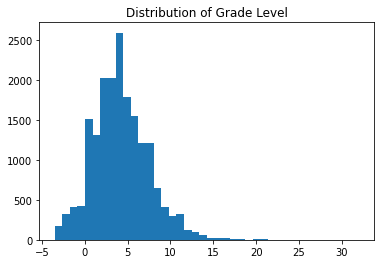

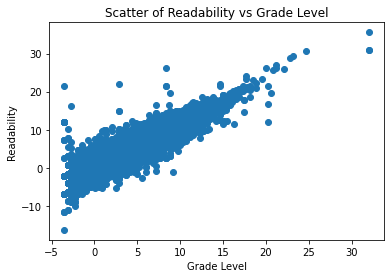

In [ ]:
sample_text = "And there are more pets in Japan than there are children under 15. You can't be a pets 'OWNER' in Boulder but you can be their guardian. "
level = textstat.flesch_kincaid_grade(sample_text)
print('message: ', df.iloc[5]["message"])
print('grade  : ', level)

plt.title('Distribution of Grade Level')
plt.hist(df["grade_level"], bins=40)
plt.show()

plt.title('Scatter of Readability vs Grade Level')
plt.xlabel('Grade Level')
plt.ylabel('Readability')
plt.scatter(df["grade_level"], df["readability"])
plt.show()

Before we move on to any classification, lets see how the distribution of some of our statistics varies depending on the sentiment of the message. Notice that the distrbution for each of these features seems to be almost the same regardless of the sentiment. This indicates that they may not have very strong predictive power. 

4


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


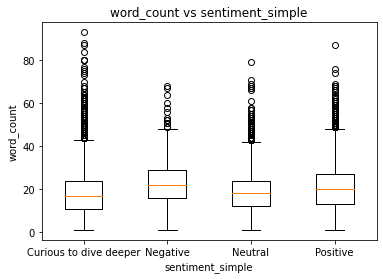

4


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


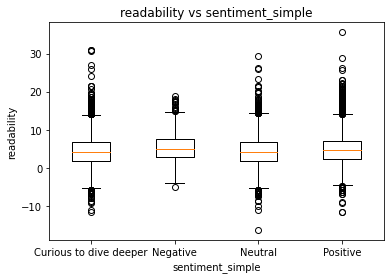

4


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


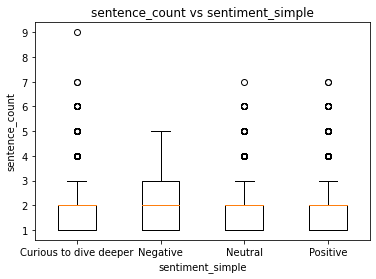

In [ ]:
ranked_sentiments = ["Curious to dive deeper", "Negative", "Neutral", "Positive"]
boxplot_values(df, "word_count", "sentiment_simple", feature_names=ranked_sentiments)
boxplot_values(df, "readability", "sentiment_simple", feature_names=ranked_sentiments)
boxplot_values(df, "sentence_count", "sentiment_simple", feature_names=ranked_sentiments)

### Classification with Counts

Unfortunately, though, while these features can generate a lot of superficial information about what a text looks like, for questions about the content or quality of a text, they are often very weak indicators. In the code below we see that using these features to try and predict labels like the sentiment of an individual produces almost no accuracy about chance (at best, a kappa of 0.04). 

This is in line with what we saw in our previous box plots. The distribution of these features are pretty much the same regardless of what the sentiment is. Therefore, they are poor predictors of the sentiment class. 

In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
stat_features = ["syllable_count", "word_count", "sentence_count", "difficult_words", "readability", "grade_level"]

feature_set = stat_features

# Compare models and display final result
sorted_sentiments = ["Curious to dive deeper", "Negative", "Neutral", "Positive"]
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set, "sentiment_simple", noisy = 'quiet', labels=sorted_sentiments)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    

Decision Tree: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.032
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.044
-------------
Best classifier is: Logistic Regression 
With K=0.044.


## Lexicon-Based Representations

We can now move to starting to pull out features of a text from lexicons, carefully designed word lists that attempt to capture specific concepts out of a text. 

For this example we'll use the word lists from the 2001 edition of LIWC, the most frequently cited library of word lexicons available today. There are newer editions, but they are paid products and I don't want you to get in trouble; but for this old and outdated version, the risk is pretty low.

The idea here is that now we are not just interested in the overall structure of the message grammatically. Instead, we are now also interested in some of the semantic elements present in the message. 

### Examining the Lexicon
Let's start by loading the lexicon so we can take a look at what categories it contains as well as what words are in a given category. 

In [ ]:
# Load the LIWC lexicon (unfortunately, this is a little complex)
liwc_in = open("liwc2001.dic").readlines()
mode = "initial"

category_names = {}
word_to_categories = {}
category_to_words = {}

for row in liwc_in:
    line = row.strip()
    if line == "%":
        if mode == "initial":
            mode = "categories"
        elif mode == "categories":
            mode = "dictionary"
    elif len(line) > 0:
        contents = line.split()
        if mode == "categories":
            num = contents[0]
            if len(num) < 2:
              num = f"0{num}"
            category_names[num] = contents[1]
        if mode == "dictionary":
            key = contents[0]
            word_to_categories[key] = []
            key_cats = contents[1:]
            for cat in key_cats:
                word_to_categories[key].append(cat)
                if cat not in category_to_words:
                    category_to_words[cat] = []
                category_to_words[cat].append(key)

# Then display the categories present in the lexicon
print(f"{len(word_to_categories)} words in lexicons.")
print("Category name: Category ID")
for k, v in category_names.items():
  print(f"{v}: {k}")

2340 words in lexicons.
Category name: Category ID
Pronoun: 01
I: 02
We: 03
Self: 04
You: 05
Other: 06
Negate: 07
Assent: 08
Article: 09
Preps: 10
Number: 11
Affect: 12
Posemo: 13
Posfeel: 14
Optim: 15
Negemo: 16
Anx: 17
Anger: 18
Sad: 19
Cogmech: 20
Cause: 21
Insight: 22
Discrep: 23
Inhib: 24
Tentat: 25
Certain: 26
Senses: 27
See: 28
Hear: 29
Feel: 30
Social: 31
Comm: 32
Othref: 33
Friends: 34
Family: 35
Humans: 36
Time: 37
Past: 38
Present: 39
Future: 40
Space: 41
Up: 42
Down: 43
Incl: 44
Excl: 45
Motion: 46
Occup: 47
School: 48
Job: 49
Achieve: 50
Leisure: 51
Home: 52
Sports: 53
TV: 54
Music: 55
Money: 56
Metaph: 57
Relig: 58
Death: 59
Physcal: 60
Body: 61
Sexual: 62
Eating: 63
Sleep: 64
Groom: 65
Swear: 66
Nonfl: 67
Fillers: 68
Similes: 69
Laugh: 70


In [ ]:
# Let's look within some of these categories to see what types of words are included
pos_emotions = category_to_words["13"]
i_pronouns = category_to_words["02"]
money_words = category_to_word["50"]
print('Positive Emotion Words')
print(pos_emotions)
print()
print('First Person Singular Pronoun Words')
print(i_pronouns)

"I've carefully accepted my awesome award"

Positive Emotion Words
['accept', 'accepta*', 'accepted', 'accepting', 'accepts', 'active*', 'admir*', 'ador*', 'advantage*', 'adventur*', 'affection*', 'agree*', 'alert*', 'amaz*', 'amus*', 'assur*', 'attachment*', 'attract*', 'award*', 'awesome*', 'beaut*', 'benefit', 'benefits', 'benign', 'best', 'better', 'bless*', 'bold', 'brave*', 'bright*', 'brillian*', 'calm*', 'care', 'cared', 'carefree', 'careful*', 'cares', 'caring', 'casual*', 'certain*', 'challeng*', 'charm*', 'cheer', 'cheered', 'cheerf*', 'cherish*', 'chuckl*', 'clever*', 'comfort*', 'commitment*', 'concentrat*', 'confidence*', 'confidently', 'confront*', 'considerate', 'contented*', 'control*', 'convinc*', 'courag*', 'create*', 'creating', 'creative*', 'cute*', 'daring', 'darling', 'dear', 'definite*', 'delicate*', 'delicious*', 'deligh*', 'determina*', 'determined', 'devot*', 'digni*', 'divine*', 'dynam*', 'ease*', 'easy*', 'ecsta*', 'efficien*', 'elegant*', 'encourag*', 'energ*', 'engaging', 'enjoy*', 'entertain*', 'e

### Creating variables based on the lexicon
Now lets create a new dataframe using these lexicon categories. We can do this by adding a new column for each category in the lexicon and making the value in that column equal to the number of words from that category present in the message. 

In [ ]:
# First lets make a copy of the data that we can play with and add a column that
# contains the message split into words
liwc_df = df.loc[:, ["message", "sentiment_simple", "rating_simple"]]
liwc_df["message_splits"] = [x.lower().split() for x in liwc_df["message"]]
liwc_df.head()

,message,sentiment_simple,rating_simple,message_splits
191,"Naming a cloned cat ""copy cat"", that's cute.",Neutral,Positive,"[naming, a, cloned, cat, ""copy, cat"",, that's,..."
192,You must have ESP. I was going to tell you teh...,Negative,Positive,"[you, must, have, esp., i, was, going, to, tel..."
193,Really? That's awful to hear!,Positive,Neutral/Negative,"[really?, that's, awful, to, hear!]"
194,Of Roosevelt's 20 pets two were a bear and hyena!,Positive,Neutral/Negative,"[of, roosevelt's, 20, pets, two, were, a, bear..."
195,"Whoa, cool! I know he seemed to be quite the a...",Positive,Neutral/Negative,"[whoa,, cool!, i, know, he, seemed, to, be, qu..."


In [ ]:
# Now, lets define and test some functions to compute the number of words 
# from a given category present in a split message
def count_exact_matches(key, split_string):
    count = 0
    for token in split_string:
        if key == token:
            count += 1 
    return count

def count_approx_matches(key, split_string):
    count = 0
    prefix = key[:-1]
    for token in split_string:
        if token.startswith(prefix):
            count += 1
    return count

def count_category_matches(split_string, category):
    category_matches = 0
    for key in category:
        if key[-1] == "*":
            category_matches += count_approx_matches(key, split_string)
        else:
            category_matches += count_exact_matches(key, split_string)
    return category_matches

test_string = "I've carefully accepted my awesome award"
split_string = test_string.lower().split()
pos_matches = count_category_matches(split_string, pos_emotions)
i_matches = count_category_matches(split_string, i_pronouns)

print(f"Positive words: {pos_matches}")
print(f"First-person pronouns: {i_matches}")

Positive words: 4
First-person pronouns: 2


In [ ]:
# Now lets apply this function to every message for every category 
# Since we are using a lot of for loops, this can be SLOW
# as it is a very computationally and time intensive operation
for k, v in category_names.items():
    print('Now encoding: ', v, '...')
    if k in category_to_words.keys():
      category_keys = category_to_words[k]
      %time matches = liwc_df["message_splits"].apply(lambda x: count_category_matches(x, category_keys))
      liwc_df[v] = matches

Now encoding:  Pronoun ...
CPU times: user 1.83 s, sys: 5.53 ms, total: 1.83 s
Wall time: 1.82 s
Now encoding:  I ...
CPU times: user 194 ms, sys: 990 µs, total: 195 ms
Wall time: 194 ms
Now encoding:  We ...
CPU times: user 234 ms, sys: 3.06 ms, total: 237 ms
Wall time: 238 ms
Now encoding:  Self ...
CPU times: user 422 ms, sys: 2.44 ms, total: 425 ms
Wall time: 423 ms
Now encoding:  You ...
CPU times: user 335 ms, sys: 1.35 ms, total: 336 ms
Wall time: 336 ms
Now encoding:  Other ...
CPU times: user 492 ms, sys: 2.49 ms, total: 494 ms
Wall time: 491 ms
Now encoding:  Negate ...
CPU times: user 769 ms, sys: 594 µs, total: 770 ms
Wall time: 768 ms
Now encoding:  Assent ...
CPU times: user 556 ms, sys: 1.92 ms, total: 558 ms
Wall time: 555 ms
Now encoding:  Article ...
CPU times: user 76.9 ms, sys: 0 ns, total: 76.9 ms
Wall time: 76.2 ms
Now encoding:  Preps ...
CPU times: user 1.03 s, sys: 2.87 ms, total: 1.03 s
Wall time: 1.04 s
Now encoding:  Number ...
CPU times: user 1.13 s, sys: 5

In [ ]:
# Let's see what our dataframe looks like now
liwc_df.loc[:, liwc_df.columns[5:]]

,I,We,Self,You,Other,Negate,Assent,Article,Preps,Number,...,Physcal,Body,Sexual,Eating,Sleep,Groom,Swear,Nonfl,Fillers,Laugh
191,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
192,2,0,2,2,0,0,0,3,6,0,...,0,0,0,0,0,0,0,0,0,0
193,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
195,1,0,1,0,1,0,0,1,1,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188192,3,0,3,0,2,0,0,2,4,1,...,0,0,0,0,0,0,0,0,0,0
188193,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
188194,0,0,0,0,2,0,0,1,4,0,...,1,1,0,0,0,0,0,0,0,0
188195,1,0,1,0,0,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0


### Classification with Lexicons

In the example below we try using these lexicon features for making predictions about sentiments. The task is still challenging and the results are not great but we see a clear increase in our ability to make predictions, with our new best kappa value being 0.118. 

In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
gold_features = ["turn_rating"]
liwc_features = list(liwc_df.columns[5:])

feature_set = liwc_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, liwc_df, feature_set, "sentiment_simple", noisy = 'quiet', labels=sorted_sentiments)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    

Decision Tree: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.079
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.116
-------------
Best classifier is: Logistic Regression 
With K=0.116.


## Bag-of-Words Representations

The Bag-of-Words (BOW) representation is another pretty intuitive way to represent any given text. We simply throw away the order of the words in the text and, instead, we just represent the text as the set of words contained in it. For example, "I love Machine Learning" becomes the unordered set ["I", "love", "Machine", "Learning"]. This gives us a way to compare between different documents as well, because we can just check how similar their corresponding sets of words are! Like with the previous two methods, the BOW model does not capture everything about the text, but it does a pretty good job. [Here is some more on BOW models](https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428)

In [ ]:
vocab_size = 1000

# By default we can build a unigram model - capturing individual words only
vectorizer = CountVectorizer(max_features=vocab_size)
X = vectorizer.fit_transform(df["message"])

# Lets check the first 20 words in our dictionary (or vocabulary)
for k in list(vectorizer.vocabulary_.keys())[:20]:
  print(f"{k}: {vectorizer.vocabulary_[k]}")

cat: 160
copy: 213
that: 846
you: 993
must: 569
have: 391
was: 932
going: 363
to: 875
tell: 838
same: 727
thing: 858
sad: 725
story: 808
there: 854
are: 73
less: 496
in: 434
the: 848
wild: 961


In [ ]:
# Now lets make a DataFrame with our BOW model representations for each message
bow_df = pd.DataFrame(X.toarray())
column_names = [str(i) for i in range(vocab_size)]

# Make the column names the words
for k, v in vectorizer.vocabulary_.items():
  column_names[v] = k
bow_df.columns = column_names

# Add our Y labels to our DataFrame
bow_df["rating"] = df["rating_simple"].values
bow_df["sentiment"] = df["sentiment_simple"].values
# Take a look at our DataFrame
bow_df

,000,10,100,11,12,13,15,20,2000,2005,...,york,you,young,younger,your,yourself,youtube,zimbabwe,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18610,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive
18611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive


# Naive Bayes

Naive Bayes' classifiers are classifiers based heavily on Bayes' Rule:

$$P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}$$

The idea is that we  want to compute $P(Y|X)$, but this is really difficult. So instead, we calculate the easier to compute values on the right. We can compute $P(Y)$ to be the distribution of class labels in the training set, We then compute $P(X|Y)$ for each $X,Y$ pair. In our case, we compute the probability of finding a word $X$ in a message of class $Y$ for each class and word in our dictionary. Finally, we assume that $P(X)$ comes from some nice distribution (usually a uniform distribution because we assume that the probability of getting any particular input is the same). 

This gives us 3 computable steps to develop a classifier we can use to compute the probability of getting each $Y$ for a given $X$ so we can find the most probable class. You may notice that the equations I listed above were for computing the probability of $Y$ given one $X$, but in reality we will be computing the conditional probability of $Y$ given many known random variables $X$. We can do these computations using basic probability laws -- but we are forced to make the assumption that each of our $Xs$ are conditionally independent from one another, which is rarely actually true. 

[Here is some more info on Naive Bayes](https://medium.com/datadriveninvestor/a-gentle-introduction-to-naive-bayes-classifier-9d7c4256c999)


## Maximum likelihood estimation of probabilities by hand

First, we count overall frequencies for each possible label $Y$ so we can calculate $P(Y)$ for each label $Y$ 

In [ ]:
target_label = "sentiment"

# First, get priors for the classes as a whole
print('Distribution of ' + target_label)
print(bow_df[target_label].value_counts())

total_count = len(bow_df)
prior_probabilities = bow_df[target_label].value_counts()/total_count
print('\nPrior Probabilities')
print(prior_probabilities.to_dict())

Distribution of sentiment
Curious to dive deeper    7983
Positive                  5801
Neutral                   4268
Negative                   562
Name: sentiment, dtype: int64

Prior Probabilities
{'Curious to dive deeper': 0.4288707424519179, 'Positive': 0.3116471473084775, 'Neutral': 0.229289781884603, 'Negative': 0.030192328355001612}


Then, we calculate frequencies of $P(word | Y)$ for each word and value of $Y$.

In [ ]:
# Find data subsets for each label
label_subsets = {}
for label in bow_df[target_label].unique():
  label_subset = bow_df.loc[bow_df[target_label] == label]
  label_subsets[label] = label_subset

word_probabilities = {}
# for each word in our list of words
for word in bow_df.columns[:-2]:
  word_probabilities[word] = {}
  print(f"'{word}' appears in...")

  # For each label in our list of classes
  for label in bow_df[target_label].unique():
    # Compute P(X|Y)
    word_appearances = label_subsets[label].loc[label_subsets[label][word] > 0]
    word_conditional_probability = len(word_appearances) / len(label_subset)

    # Store and print P(X|Y)
    word_probabilities[word][label] = word_conditional_probability
    print(f"   {100*word_conditional_probability:.1f}% of {label} instances.")

'000' appears in...
   0.3% of Neutral instances.
   0.0% of Negative instances.
   0.7% of Positive instances.
   0.7% of Curious to dive deeper instances.
'10' appears in...
   0.4% of Neutral instances.
   0.1% of Negative instances.
   0.7% of Positive instances.
   0.5% of Curious to dive deeper instances.
'100' appears in...
   0.3% of Neutral instances.
   0.1% of Negative instances.
   0.6% of Positive instances.
   0.5% of Curious to dive deeper instances.
'11' appears in...
   0.1% of Neutral instances.
   0.0% of Negative instances.
   0.3% of Positive instances.
   0.2% of Curious to dive deeper instances.
'12' appears in...
   0.0% of Neutral instances.
   0.0% of Negative instances.
   0.2% of Positive instances.
   0.3% of Curious to dive deeper instances.
'13' appears in...
   0.1% of Neutral instances.
   0.0% of Negative instances.
   0.2% of Positive instances.
   0.2% of Curious to dive deeper instances.
'15' appears in...
   0.1% of Neutral instances.
   0.0% of Ne

**Now we can check and see that some words show up much more often in positive comments than negative ones.** \\
 For example, we see that "definitely" shows up over 20 times as often in positive comments as it does in negative comments.

In [ ]:
# Lets find the words that show up much more often in positive ratings than negative ones
for word in word_probabilities:
  if word_probabilities[word]["Positive"] / (word_probabilities[word]["Curious to dive deeper"] + 1e-9) > 10: # 1e-9 helps protect from division by 0
    print(word)
    for l in word_probabilities[word].keys():
      print(f"   {l}:{word_probabilities[word][l]}")

750
   Neutral:0.0010021295252411375
   Negative:0.0
   Positive:0.0033821871476888386
   Curious to dive deeper:0.0010021295252411375


**We can also try to classify a made up message that we have created to see what the computation for a prediction looks like**






In [ ]:
# Let's see what happens when we classify this made up message
positive_sentence = "personally I find that it's worth while watching youtube videos"

# alternate example:
# positive_sentence = "yep my wife uses a ton of bandwidth at my university"

# First we split the sentence into words (BOW model)
positive_sentence_split = positive_sentence.lower().split()

multiplied_probabilities = {}
normalizing = 0
# For each label (and its prior probability)
for label, prior_probability in prior_probabilities.items():
    # Print the label and its prior probability P(Y)
    print(f"{label} {prior_probability}")

    # For each word in the sentence
    running_probability = prior_probability
    for word in positive_sentence_split:
        # Get the probability P(X|Y)
        if word in word_probabilities.keys():
            cond_prob = word_probabilities[word][label]

        # Clip the minimum probability value
        if cond_prob == 0:
            cond_prob = 0.0001

        # Print the probability
        print(f"  {word} {cond_prob}")
        
        # Update our running probability using P(X|Y)
        running_probability = running_probability * cond_prob
        
    # Save some info for normalization and later comparison
    normalizing += running_probability
    multiplied_probabilities[label] = running_probability
    print(f"Total: {running_probability}")
    print("------")

# Print the final normalized probabilities for each class
for label in multiplied_probabilities:
    normalized_probability = multiplied_probabilities[label] / normalizing
    print(f"Final probability of {label}: {100*normalized_probability:.3f}%")

Curious to dive deeper 0.4288707424519179
  personally 0.0008768633345859953
  i 0.0008768633345859953
  find 0.011023424777652512
  that 0.3766754353000125
  it's 0.3766754353000125
  worth 0.006388575723412251
  while 0.006388575723412251
  watching 0.008392834773894527
  youtube 0.00864336715520481
  videos 0.0023800576224477015
Total: 3.634365338977039e-21
------
Positive 0.3116471473084775
  personally 0.002004259050482275
  i 0.002004259050482275
  find 0.00864336715520481
  that 0.3317048728548165
  it's 0.3317048728548165
  worth 0.0080170362019291
  while 0.00914443191782538
  watching 0.008768633345859953
  youtube 0.01027182763372166
  videos 0.0025053238131028436
Total: 1.9695708270160354e-20
------
Neutral 0.229289781884603
  personally 0.002254791431792559
  i 0.002254791431792559
  find 0.004760115244895403
  that 0.1906551421771264
  it's 0.1906551421771264
  worth 0.0016284604785168483
  while 0.005511712388826256
  watching 0.004509582863585118
  youtube 0.00601277715

**It is often numerically unstable to deal with super small numbers like this. One way to rectify this is by using log-probabilities**

Notice that the values are now no longer super small, which helps with keep our calculations stable. Furthermore, although the numbers are different the ordering is the same, which is all that matters for our prediction. If we wanted to get back to the original probabilities, we could do that at the end by noticing that $P(Y|X) = 2 ^ {log_2P(Y|X)}$

In [ ]:
positive_sentence = "yep my wife uses a ton of bandwidth at my university"

# alternate example:
# positive_sentence = "personally I find that it's worth while watching youtube videos"

# Split the sentence (BOW model)
positive_sentence_split = positive_sentence.lower().split()

# For each label/prior probability
summed_log_probabilities = {}
for label, prior_probability in prior_probabilities.items():
    # Print the label and P(Y) and get its log
    log_running_probability = math.log2(prior_probability)
    print(f"{label} {log_running_probability}")

    # For each word in the sentence
    for word in positive_sentence_split:
        # Get P(X|Y) 
        if word in word_probabilities.keys():
            cond_prob = word_probabilities[word][label]

        # Clip the minimum probability
        if cond_prob == 0:
            cond_prob = 0.0001
        
        # Compute log(P(X|Y)) and display it
        log_cond_prob = math.log2(cond_prob)
        print(f"  {word} {log_cond_prob}")

        # Update our log running probability
        log_running_probability = log_running_probability + log_cond_prob

    # Store and print the important values
    summed_log_probabilities[label] = log_running_probability
    print(f"Total: {log_running_probability}")
    print("------")

for label in summed_log_probabilities:
    log_probability = summed_log_probabilities[label]
    print(f"Final log-probability of {label}: {log_probability:.3f}")

Curious to dive deeper -1.2213851961656224
  yep -7.7532619301144265
  my -4.6273249410494515
  wife -9.055824700134858
  uses -8.875252454493037
  a -8.875252454493037
  ton -9.962715295743376
  of -1.9431245673854953
  bandwidth -9.50328367710608
  at -4.337006452678911
  my -4.6273249410494515
  university -9.37775279502222
Total: -80.15950940543597
------
Positive -1.682014587923095
  yep -7.008518985356501
  my -4.681944525612773
  wife -8.439153339686364
  uses -8.155360373685772
  a -8.155360373685772
  ton -8.50328367710608
  of -2.1937039746463616
  bandwidth -8.71478778229979
  at -4.592027888936158
  my -4.681944525612773
  university -9.055824700134858
Total: -75.86392473468631
------
Neutral -2.1247560310845737
  yep -8.875252454493037
  my -5.536450541041278
  wife -9.792790294301064
  uses -9.37775279502222
  a -9.37775279502222
  ton -10.640787200856014
  of -2.7544809374035877
  bandwidth -9.37775279502222
  at -5.117225244799001
  my -5.536450541041278
  university -9

## Classification with Naive Bayes and Bag-of-Words features

Here we show how you can call Naive Bayes from within Scikit-learn. This example also shows one hyperparameter to tune, which is the choice of exactly how to calculate probabilities (all three approaches are similar to the math above, but each makes slight adjustments behind the scenes).

Now we have a model that is both very fast and more effective than any of the count- or lexicon-based features above. Though the individual columns are very sparse, the overall representation of the text is expressive enough to capture much more nuance about what's going on in the data.



In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
bow_features = column_names
feature_set = bow_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bow_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.223
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.227
-------------
Best classifier is: Complement NB 
With K=0.238.


### Hyperparameter: N-Grams
One of the biggest problems with the BOW model is that you completely lose the ordering of the words. For example, in the BOW model the following sentences are identically represented even though their meanings are very different.

- Alex loves to run but hates cats.
- Alex loves cats but hates to run.

One way that we can solve this is by taking n-grams of words (sequences of n consecutive words. For example, the two previous sentences would break down as follows for 3 grams:

- [Alex loves to, loves to run, to run but, run but hates, but hates cats]
- [Alex loves cats, loves cats but, cats but hates, but hates to, hates to run]

We can see that, in this new representation, the adjectives "love" and "hate" are properly linked to their corresponding noun. This means that this n-gram representation is much more effective at describing the text. 

However, there are many more possible n-grams than there are just words, since the number of possible n-grams of length n is given by (number of possible words) ^ n. This can potentially be dangerous, because, if our dataset is not big enough, then there are many n-grams we are likely to not encounter often. This gives us less accurate probability measures $P(X|Y)$ and can increase the dimensionality of our data greatly - opening up the possibiilty of overfitting



In [ ]:
# Create a vocab of n-grams from the dataframe
def ngrams(df, vocab_size = 1000, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,max_n))
  X = vectorizer.fit_transform(df["message"])

  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names

  bow_df["rating"] = df["rating_simple"].reset_index()['rating_simple']
  bow_df["sentiment"] = df["sentiment_simple"].reset_index()['sentiment_simple']
  return bow_df

# Unigrams DataFrame
unigram_df = ngrams(df, max_n=1)
unigram_df

,000,10,100,11,12,13,15,20,2000,2005,...,york,you,young,younger,your,yourself,youtube,zimbabwe,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18610,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive
18611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive


In [ ]:
# DataFrame of Bigrams
bigram_df = ngrams(liwc_df, vocab_size = 5000, max_n=2)
bigram_df

,000,000 per,000 year,000 years,10,10 episodes,10 people,10 years,100,100 shows,...,yourself,youtube,youtube is,yup,zealand,zimbabwe,zimbabwe was,zuckerberg,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18610,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive
18611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive


In [ ]:
  # DataFrame of Trigrams
  trigram_df = ngrams(liwc_df, vocab_size = 5000, max_n=3)
  trigram_df

,000,000 per,000 per episode,000 year,000 years,10,10 episodes,10 people,10 years,100,...,youtube,youtube is,yup,zealand,zimbabwe,zimbabwe was,zimbabwe was called,zuckerberg,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18610,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive
18611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive


**Let's see how classifier performance can vary across different levels of n-grams**

In [ ]:
### Setup classifiers and metrics to be used on all n-grams
# Pick Classifiers to Compare
classifiers = {
    "Bernoulli NB": BernoulliNB(),
    "Complement NB": ComplementNB(), 
    "Multinomial NB": MultinomialNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

### Compare classifiers on unigrams ###
# Pick features to use
feature_set = list(unigram_df.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best unigram classifier is: {best_name} \nWith K={best:.3f}.")    

### Compare classifiers on bigrams ###
# Pick features to use
feature_set = list(bigram_df.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best bigram classifier is: {best_name} \nWith K={best:.3f}.")    

### Compare classifiers on trigrams ###
# Pick features to use
feature_set = list(trigram_df.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, trigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best trigram classifier is: {best_name} \nWith K={best:.3f}.")    


Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.222
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.237
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.225
-------------
Best unigram classifier is: Complement NB 
With K=0.237.
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.241
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.253
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.249
-------------
Best bigram classifier is: Complement NB 
With K=0.253.
Bernoulli NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.241
-------------
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.255
-------------
Multinomial NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.248
-------------
Best trigram classifier is: Complement NB 
With K=

This ends the day - once again we're ending on a successful end-to-end implementation of a classifier; this time instead of starting with a clean set of tabular features, we started with complex unstructured input and tried out multiple different representations, landing on a successful combination. Our best possible model (with unigram and bigram features, using a complement equation for calculating probabilities) drasically outperformed our simple length-based features. 

Next week, we'll see if we can get even more improvement by adding more sophisticated natural language processing into our analysis.